In [1]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../../azimuth.env")

# Add PATH_ROOT to Python path
import sys
sys.path.append(os.getenv("PATH_ROOT"))

print(f'PATH_ROOT: {os.getenv("PATH_ROOT")}')

PATH_ROOT: /Users/thinhhoang/Documents/alpha-azimuth/


# Thomas-Jensen Problem Generation

We use the Thomas-Jensen Process to generate the transit process of aircraft through an airspace (without turns).

In [2]:
# Testing Thomas-Jensen Transit Process

import MARTINI.airspace.randomize_airspace as randomize_airspace
import MARTINI.arrivals.thomas as thomas
import MARTINI.airspace.geo as geo
import MARTINI.airspace.intersect as intersect

# Generate a polygon
polygon, area = randomize_airspace.generate_unit_polygon(5, 500, seed=69420)

entry_points, exit_points, velocity_vectors, parent_indices = thomas.generate_problem_thomas_jensen(polygon, lambda_parent=8e-3, mu=2, sigma=12, min_dist_to_vertex=42, min_transit_length=96)
print(f'There are {len(entry_points)} entries generated')
print(f'There are {len(exit_points)} exits generated')
print(f'There are {len(velocity_vectors)} velocity vectors generated')


There are 21 entries generated
There are 21 exits generated
There are 21 velocity vectors generated


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


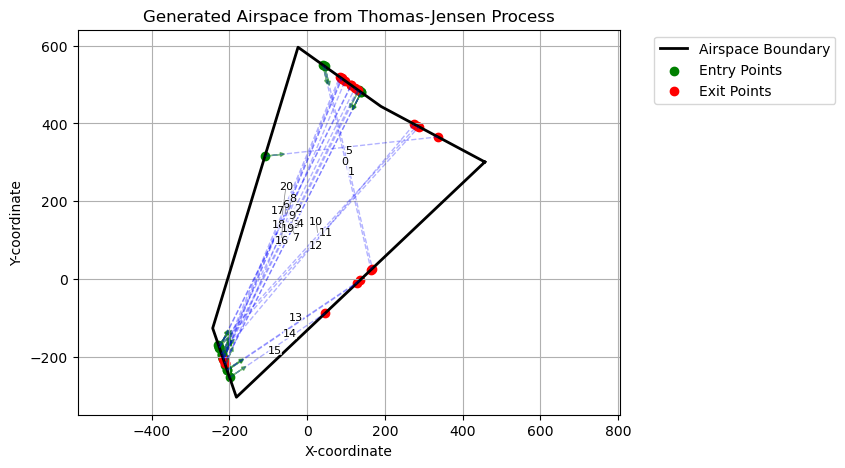

In [3]:
thomas.visualize_airspace(polygon, entry_points, exit_points, velocity_vectors)

# TRAJCLUS-HDBSCAN (TRC) for Flow Structuring

In [4]:
import numpy as np
import matplotlib.pyplot as plt


In [5]:
trajectories = [[x, y] for x, y in zip(entry_points, exit_points)]
trajectories = np.array(trajectories)

print(f'There are {len(trajectories)} trajectories generated')

There are 21 trajectories generated


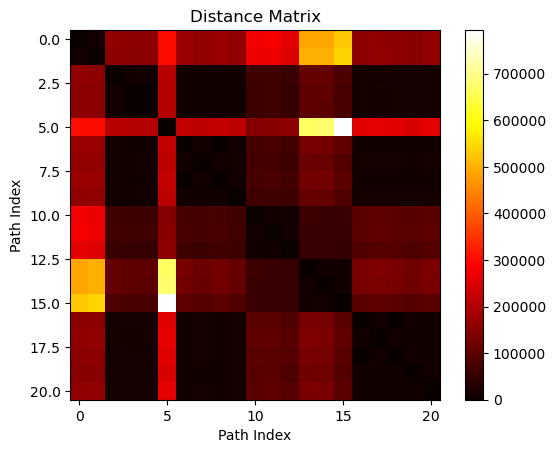

In [6]:
# Compute the distance matrix
from ALPHA.dirichlet.trajclus_features import compute_distance_matrix
from ALPHA.dirichlet.hdbs import perform_clustering
from ALPHA.dirichlet.trajclus_features import compute_segment_features_auto

distance_matrix = compute_distance_matrix(trajectories)
# Visualize the distance matrix
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Distance Matrix')
plt.xlabel('Path Index')
plt.ylabel('Path Index')
plt.show()



In [14]:
# Perform clustering
cluster_labels, clusterer = perform_clustering(trajectories, min_samples=3,
                                               cluster_selection_epsilon=0.0,
                                               algo='hdbscan',
                                               min_cluster_size=3)

print(f'There are {len(np.unique(cluster_labels))} clusters')


There are 3 clusters


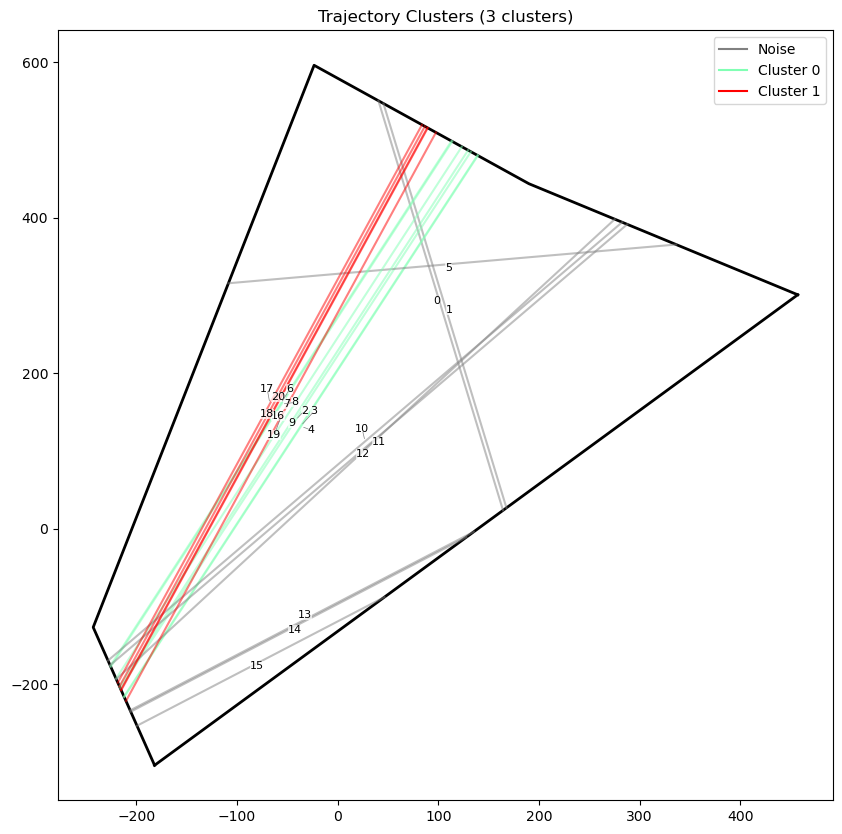

In [15]:
# Plot the airspace boundary
plt.figure(figsize=(10, 10))
plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Airspace Boundary')
plt.plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'k-', linewidth=2)

# Plot the clusters
unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Create a legend handle list and color mapping
legend_elements = []
color_dict = {}  # Create a mapping of label to color

for idx, (label, color) in enumerate(zip(unique_labels, colors)):
    if label == -1:
        color_dict[label] = 'gray'
        legend_elements.append(plt.Line2D([0], [0], color='gray', label='Noise'))
    else:
        color_dict[label] = color
        legend_elements.append(plt.Line2D([0], [0], color=color, label=f'Cluster {label}'))
        
# Plot trajectories
for i in range(trajectories.shape[0]):
    color = color_dict[cluster_labels[i]]
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], c=color, alpha=0.5)

# Add trajectory labels with overlap handling
texts = []
for i in range(trajectories.shape[0]):
    # Get midpoint of trajectory for initial text position
    mid_x = np.mean(trajectories[i, :, 0])
    mid_y = np.mean(trajectories[i, :, 1])
    
    # Add text with white background for better visibility
    text = plt.text(mid_x, mid_y, str(i),
                   fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0),
                   horizontalalignment='center',
                   verticalalignment='center')
    texts.append(text)

# Try to prevent text overlap using adjustText if available
try:
    from adjustText import adjust_text
    adjust_text(texts,
               arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
               expand_points=(1.5, 1.5))
except ImportError:
    print('adjustText not available, keeping simple text labels')
    pass

plt.title(f'Trajectory Clusters ({len(unique_labels)} clusters)')
plt.legend(handles=legend_elements)
plt.show()


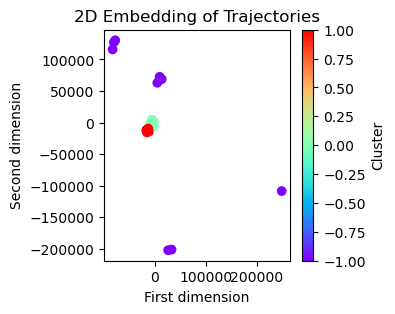

In [16]:
from sklearn.manifold import MDS

# Create MDS embedding from distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
trajectory_embedding = mds.fit_transform(distance_matrix)

# Create scatter plot
plt.figure(figsize=(3, 3))
scatter = plt.scatter(trajectory_embedding[:, 0], trajectory_embedding[:, 1], 
                     c=cluster_labels, cmap='rainbow')

# # Add text labels for each point
# for i, (x, y) in enumerate(trajectory_embedding):
#     plt.text(x, y, str(i), 
#              fontsize=8,
#              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0),
#              horizontalalignment='center', 
#              verticalalignment='center')


plt.colorbar(scatter, label='Cluster')
plt.title('2D Embedding of Trajectories')
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.show()

# Gap-emphasized Clustering

In [17]:

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import hdbscan

def analyze_cluster_spacing(distance_matrix):
    """
    Analyze the spacing between points to determine optimal HDBSCAN parameters
    Returns recommended min_cluster_size and min_samples
    """
    # Calculate distances to k nearest neighbors using distance matrix
    n_neighbors = 5
    distances = np.sort(distance_matrix, axis=1)[:, 1:n_neighbors+1]  # Skip first neighbor (self)
    
    # Analyze the distribution of distances
    mean_distances = distances.mean(axis=1)
    
    # Plot distance distribution
    plt.figure(figsize=(10, 4))
    plt.hist(mean_distances, bins=30)
    plt.title('Distribution of Average Distances to k Nearest Neighbors')
    plt.xlabel('Average Distance')
    plt.ylabel('Frequency')
    plt.show()
    
    # Calculate statistics for parameter recommendations
    distance_threshold = np.percentile(mean_distances, 75)  # 75th percentile
    
    # Recommend parameters based on distance distribution
    recommended_min_samples = max(3, int(np.ceil(distance_matrix.shape[0] * 0.01)))  # At least 3 or 1% of data
    recommended_min_cluster_size = max(3, int(np.ceil(distance_matrix.shape[0] * 0.02)))  # At least 3 or 2% of data
    return recommended_min_samples, recommended_min_cluster_size, distance_threshold

def gap_weighted_distance(x, y, gap_sensitivity=2.0):
    """
    Custom distance metric that emphasizes gaps between clusters
    Higher gap_sensitivity increases the emphasis on spatial gaps
    """
    basic_dist = distance_matrix[x, y]
    return basic_dist ** gap_sensitivity

def perform_sparse_clustering(X, gap_sensitivity=3.0, min_cluster_size=None, min_samples=None):
    """
    Perform HDBSCAN clustering optimized for sparse clusters
    """
    
    # If parameters aren't provided, analyze data to determine them
    if min_cluster_size is None or min_samples is None:
        recommended_min_samples, recommended_min_cluster_size, distance_threshold = analyze_cluster_spacing(X_scaled)
        min_samples = min_samples or recommended_min_samples
        min_cluster_size = min_cluster_size or recommended_min_cluster_size
    
    # Create distance matrix using gap-weighted metric
    n_samples = X.shape[0]
    distance_matrix = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            dist = gap_weighted_distance(i, j, gap_sensitivity)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    
    # Configure HDBSCAN for sparse clusters
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='precomputed',
        cluster_selection_method='eom',  # Excess of mass
        cluster_selection_epsilon=0.5,    # More liberal cluster selection
        alpha=0.5  # Lower alpha for sparser clusters
    )
    
    # Fit and predict
    labels = clusterer.fit_predict(distance_matrix)
    
    return labels, clusterer

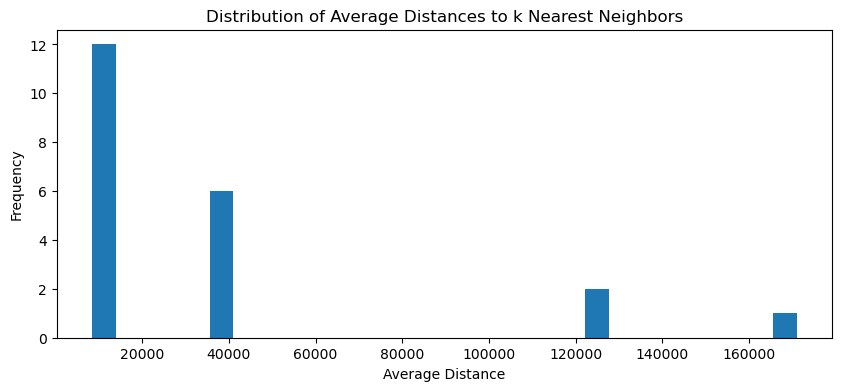

In [18]:
# Analyze your data structure
min_samples, min_cluster_size, distance_threshold = analyze_cluster_spacing(distance_matrix)
cluster_labels, _ = perform_sparse_clustering(trajectories, gap_sensitivity=2.0, min_cluster_size=min_cluster_size, min_samples=min_samples)

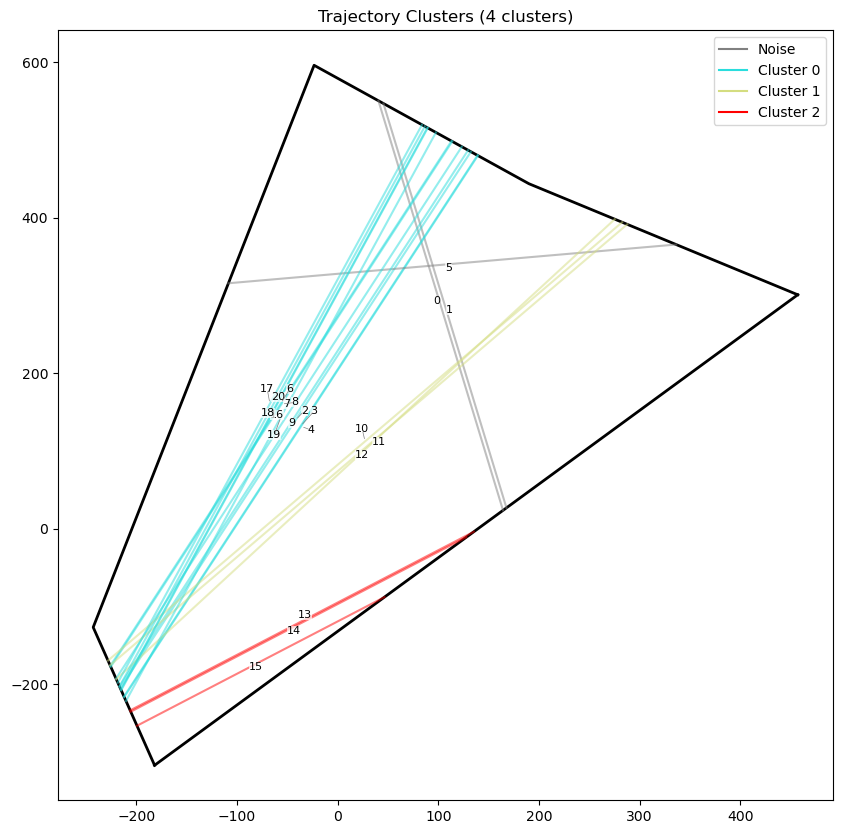

In [19]:
# Plot the airspace boundary
plt.figure(figsize=(10, 10))
plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Airspace Boundary')
plt.plot([polygon[-1, 0], polygon[0, 0]], [polygon[-1, 1], polygon[0, 1]], 'k-', linewidth=2)

# Plot the clusters
unique_labels = np.unique(cluster_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# Create a legend handle list and color mapping
legend_elements = []
color_dict = {}  # Create a mapping of label to color

for idx, (label, color) in enumerate(zip(unique_labels, colors)):
    if label == -1:
        color_dict[label] = 'gray'
        legend_elements.append(plt.Line2D([0], [0], color='gray', label='Noise'))
    else:
        color_dict[label] = color
        legend_elements.append(plt.Line2D([0], [0], color=color, label=f'Cluster {label}'))
        
# Plot trajectories
for i in range(trajectories.shape[0]):
    color = color_dict[cluster_labels[i]]
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], c=color, alpha=0.5)

# Add trajectory labels with overlap handling
texts = []
for i in range(trajectories.shape[0]):
    # Get midpoint of trajectory for initial text position
    mid_x = np.mean(trajectories[i, :, 0])
    mid_y = np.mean(trajectories[i, :, 1])
    
    # Add text with white background for better visibility
    text = plt.text(mid_x, mid_y, str(i),
                   fontsize=8,
                   bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0),
                   horizontalalignment='center',
                   verticalalignment='center')
    texts.append(text)

# Try to prevent text overlap using adjustText if available
try:
    from adjustText import adjust_text
    adjust_text(texts,
               arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
               expand_points=(1.5, 1.5))
except ImportError:
    print('adjustText not available, keeping simple text labels')
    pass

plt.title(f'Trajectory Clusters ({len(unique_labels)} clusters)')
plt.legend(handles=legend_elements)
plt.show()


It is better, but not much!

# Leiden Community Detection with Cutoff